The following notebook explores the BERT Model from the Hugging Face Library. We will fine tune the pretrained BERT Model on our data and then evaluate it on a test set. This is done using 5 fold cross validation and we have presented a confusion matrix along with various evaluation metrics to assess the performance of the model

# Data Preprocessing

## Import Libraries

In [0]:
import sys
import time
import os
import math
import copy
import string
import re
from IPython.display import clear_output

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.functional as F

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset, TensorDataset
from torch.autograd import Variable

In [0]:
#We set our device to the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.get_device_name(0)

'Tesla T4'

Here we install the Hugging Face Library which contains the BERT Model

In [0]:
!pip install transformers

     |████████████████████████████████| 552kB 41.7MB/s 
     |████████████████████████████████| 3.7MB 63.4MB/s 
     |████████████████████████████████| 870kB 71.5MB/s 
     |████████████████████████████████| 1.0MB 47.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=8dd7ac3f88ad533a69f370a7483fb8458ae6d3eab3aac0503c2f61f6ceddfaf4
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:

filepath = "gdrive/My Drive/ted_training_pairs_NLTK2.csv"

data = pd.read_csv(filepath)

sentences = data['text'].values
labels = data['label'].values

#We wish to use the uncased model so we must ensure that all sentences are in lower case

sentences = [sentences[i].lower() for i in range(len(sentences))]

In [0]:
#We encode the labels so that laughter is assigned "0" and neutral is assigned "1"

from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()
labels_enc = enc.fit_transform(labels)

print(labels[0], labels_enc[0])

laughter 0


In [0]:
from transformers import BertTokenizer

#Load the BERT Tokenizer
print("Loading BERT tokenizer...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)

Loading BERT tokenizer...


We will start by showing an example of how the BERT Model tokenizes a sentence

In [0]:
# Print the original sentence.
print(' Original: ', sentences[2])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[2]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[2])))

 Original:  if you're at a dinner party , and you say you work in education — actually , you're not often at dinner parties , frankly . 
Tokenized:  ['if', 'you', "'", 're', 'at', 'a', 'dinner', 'party', ',', 'and', 'you', 'say', 'you', 'work', 'in', 'education', '—', 'actually', ',', 'you', "'", 're', 'not', 'often', 'at', 'dinner', 'parties', ',', 'frankly', '.']
Token IDs:  [2065, 2017, 1005, 2128, 2012, 1037, 4596, 2283, 1010, 1998, 2017, 2360, 2017, 2147, 1999, 2495, 1517, 2941, 1010, 2017, 1005, 2128, 2025, 2411, 2012, 4596, 4243, 1010, 19597, 1012]


In [0]:
# We will now tokenize every sentence in our data

sentence_tokens = []

for sentence in sentences:
  encoded_sent = tokenizer.encode(sentence,
                                  add_special_tokens = True,
                                  )
  sentence_tokens.append(encoded_sent)

print("Original: ", sentences[1])
print("Tokenized: ", sentence_tokens[1])

Original:  in fact , i'm leaving . 
Tokenized:  [101, 1999, 2755, 1010, 1045, 1005, 1049, 2975, 1012, 102]


For the purpose of speeding up training as well as potentially improving training we will be truncating/padding all our sentences to a fixed length based on their sentence length distribution.

Below we find the distribution of sentence lengths. We select a maximum length by choosing the length closest to the "elbow" of the distribution

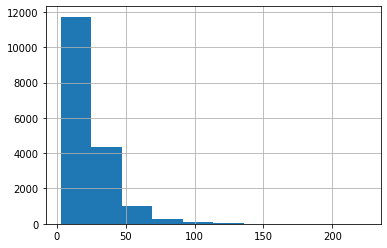

count    17466.000000
mean        23.282950
std         16.873331
min          3.000000
25%         12.000000
50%         19.000000
75%         30.000000
max        224.000000
dtype: float64

In [0]:
sentence_len = [len(x) for x in sentence_tokens]
pd.Series(sentence_len).hist()
plt.show()
pd.Series(sentence_len).describe()

In [0]:
#By carefully analysing our data we choose a maximum legnth of 30 tokens
max_len = 30

#We will use the keras padding function for convenience
from keras.preprocessing.sequence import pad_sequences

print('\nPadding/truncating all sentences to %d values...' % max_len)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
sentence_tokens = pad_sequences(sentence_tokens, maxlen=max_len, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')

Using TensorFlow backend.



Padding/truncating all sentences to 30 values...

Padding token: "[PAD]", ID: 0

Done.


As part of the input the BERT Model also requires an attention mask which will differentiate the sentence tokens from the padding tokens

In [0]:
# Create attention masks
attention_masks = []

# For each sentence...
for sent in sentence_tokens:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

attention_masks = np.array(attention_masks)

In [0]:
attention_masks.shape

(17466, 30)

In [0]:
sentence_tokens.shape

(17466, 30)

In [0]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    softmax_output = nn.functional.softmax(torch.tensor(preds), dim = 1)
    pred_flat = np.argmax(softmax_output, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(np.array(pred_flat) == labels_flat) / len(labels_flat)

In [0]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [0]:
def train(model, iterator, optimizer, scheduler):
  epoch_loss = 0
  epoch_acc = 0

  for batch in iterator:
    #Send outputs to the GPU if available
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    #Zero the gradient in our model
    model.zero_grad()

    #Retrieve the outputs of the model
    outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
    
    #Compute loss
    loss = outputs[0]
    epoch_loss += loss.item()

    #Calculate gradients 
    loss.backward()

    #Compute the accuracy
    logits = outputs[1]

    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    acc = flat_accuracy(logits, label_ids)
    epoch_acc += acc

    #Gradient clip in order to avoid potential problem of
    #vanishing and exploding gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    #Take a step in the direction of the gradient
    optimizer.step()

    #Take a step in the scheduler reducing learning rate
    scheduler.step()

  return epoch_loss/len(iterator) , epoch_acc / len(iterator)

def evaluate(model, iterator):

  epoch_loss = 0
  epoch_acc = 0

  with torch.no_grad():

    for batch in iterator:
      #Send outputs to the GPU if available
      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_labels = batch[2].to(device)

        
      outputs = model(b_input_ids, 
                      token_type_ids=None, 
                      attention_mask=b_input_mask,
                      labels=b_labels)
        
      #Compute loss
      loss = outputs[0]
      epoch_loss += loss.item()
      
      logits = outputs[1]

      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()
      
      # Calculate the accuracy for this batch of test sentences.
      acc = flat_accuracy(logits, label_ids)
      epoch_acc += acc

  return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [0]:
def plot_loss_accuracy(train_loss, valid_loss, train_acc, valid_acc):
    #plots the loss and accuracy of training and validation set during training
    # comment out to suppress plot output
    fig = plt.figure(figsize=plt.figaspect(0.2))
    ax1 = fig.add_subplot(1,2,1)
    ax1.plot(train_loss, 'b')
    ax1.plot(valid_loss, 'r')
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    ax1.legend(['Train', 'Validation'])  
    
    ax1 = fig.add_subplot(1,2,2)
    ax1.plot(train_acc, 'b')
    ax1.plot(valid_acc, 'r')
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    ax1.legend(['Train', 'Validation'])

    ltrain = np.array(train_loss)  
    least_train_epoch = np.argmin(ltrain)
    least_train_loss = min(train_loss)
    print('Lowest training loss:',least_train_loss,'achieved at epoch:',least_train_epoch)
    
    lval = np.array(valid_loss)  
    least_val_epoch = np.argmin(lval)
    least_val_loss = min(valid_loss)
    print('Lowest validation loss:',least_val_loss,'achieved at epoch:',least_val_epoch)
    
    atrain = np.array(train_acc)  
    best_train_epoch = np.argmax(atrain)
    best_train_accuracy = max(train_acc)
    print('Best training accuracy:',best_train_accuracy * 100,'achieved at epoch:',best_train_epoch)
    aval = np.array(valid_acc)  
    best_val_epoch = np.argmax(aval)
    best_val_accuracy = max(valid_acc)
    print('Best validation accuracy:',best_val_accuracy*100,'achieved at epoch:',best_val_epoch,'\n')
    
    return least_train_loss, least_val_loss, best_train_accuracy, best_val_accuracy

In [0]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score,f1_score,confusion_matrix, accuracy_score
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

# The Hugging Face Library authors reccomend that we use between 2 and 4 epochs for training
epochs = 3

skf = StratifiedKFold(5)



We will now run the training loop. We use 5-fold Cross Validation in order to compute averages and standard deviations of each metric considered

In [0]:
loss_list = []
f1_list = []
acc_list = []
auc_list = []
avloss_list = []
conf_matrices = []

for trainval_indices, test_indices in skf.split(sentence_tokens, labels_enc):
  # Load BertForSequenceClassification, the pretrained BERT model with a single 
  # linear classification layer on top. 
  model = BertForSequenceClassification.from_pretrained(
      "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
      num_labels = 2, # The number of output labels--2 for binary classification.
                      # You can increase this for multi-class tasks.   
      output_attentions = False, # Whether the model returns attentions weights.
      output_hidden_states = False, # Whether the model returns all hidden-states.
  )
  # Tell pytorch to run this model on the GPU.
  model.to(device)

  # Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
  # I believe the 'W' stands for 'Weight Decay fix"
  optimizer = AdamW(model.parameters(),
                    lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                    eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                  )

  from sklearn.model_selection import train_test_split

  train_indices, val_indices = train_test_split(trainval_indices, train_size = 0.8, shuffle = True, random_state = 2020)

  train_inputs = sentence_tokens[train_indices]
  train_masks = attention_masks[train_indices]
  train_labels = labels_enc[train_indices]

  val_inputs = sentence_tokens[val_indices]
  val_masks = attention_masks[val_indices]
  val_labels = labels_enc[val_indices]

  test_inputs = sentence_tokens[test_indices]
  test_masks = attention_masks[test_indices]
  test_labels = labels_enc[test_indices]

  train_inputs = sentence_tokens[train_indices]
  train_masks = attention_masks[train_indices]
  train_labels = labels_enc[train_indices]

  val_inputs = sentence_tokens[val_indices]
  val_masks = attention_masks[val_indices]
  val_labels = labels_enc[val_indices]

  test_inputs = sentence_tokens[test_indices]
  test_masks = attention_masks[test_indices]
  test_labels = labels_enc[test_indices]

  train_inputs[0]

  # create Tensor datasets
  train_data = TensorDataset(torch.from_numpy(train_inputs), torch.from_numpy(train_masks), torch.from_numpy(train_labels))
  val_data = TensorDataset(torch.from_numpy(val_inputs), torch.from_numpy(val_masks), torch.from_numpy(val_labels))
  test_data = TensorDataset(torch.from_numpy(test_inputs), torch.from_numpy(test_masks), torch.from_numpy(test_labels))
  # dataloaders
  batch_size = 50
  # make sure to SHUFFLE your data
  train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
  val_dataloader = DataLoader(val_data, shuffle=True, batch_size=batch_size)
  test_dataloader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

  # Total number of training steps is number of batches * number of epochs.
  total_steps = len(train_dataloader) * epochs

  # Create the learning rate scheduler.
  scheduler = get_linear_schedule_with_warmup(optimizer, 
                                              num_warmup_steps = 0, # Default value in run_glue.py
                                              num_training_steps = total_steps)
  
  import random

  # Set the seed value all over the place to make this reproducible.
  seed_val = 42

  random.seed(seed_val)
  np.random.seed(seed_val)
  torch.manual_seed(seed_val)
  torch.cuda.manual_seed_all(seed_val)

  # Store the average loss after each epoch so we can plot them.
  training_losses = []
  training_accs = []

  val_losses = []
  val_accs = []
  total_val_loss = []

  best_acc = 0

  # For each epoch...
  for epoch_i in range(0, epochs):
      
      # ========================================
      #               Training
      # ========================================
      
      # Perform one full pass over the training set.

      print("")
      print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
      print('Training...')

      # Measure how long the training epoch takes.
      t0 = time.time()

      # Put the model into training mode
      model.train()

      # For each batch of training data...
      train_loss, train_acc = train(model, train_dataloader, optimizer, scheduler)
      
      # Store the loss value for plotting the learning curve.
      training_losses.append(train_loss)
      training_accs.append(train_acc)

      print("")
      print("  Average training loss: {0:.2f}".format(train_loss))
      print("  Average training accuracy: {0: .2f}".format(train_acc))
      print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
          
      # ========================================
      #               Validation
      # ========================================
      # After the completion of each training epoch, measure our performance on
      # our validation set.

      print("")
      print("Running Validation...")

      t0 = time.time()

      # Put the model in evaluation mode--the dropout layers behave differently
      # during evaluation.
      model.eval()

      val_loss, val_acc = evaluate(model, val_dataloader)

      val_losses.append(val_loss)
      val_accs.append(val_acc)

      # Report the final accuracy for this validation run.
      print("  Loss: {0:.2f}".format(val_loss))
      print("  Accuracy: {0:.2f}".format(val_acc))
      print("  Test took: {:}".format(format_time(time.time() - t0)))

      if val_acc > best_acc:
        best_acc = val_acc

        output_dir = './model_save/'

        # Create output directory if needed
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
        model_to_save.save_pretrained(output_dir)
        tokenizer.save_pretrained(output_dir)

  print("")
  print("Training complete!\n")

  model = BertForSequenceClassification.from_pretrained(output_dir)
  model.to(device)

  print('Predicting labels for {:,} test sentences...'.format(len(test_data)))

  # Put model in evaluation mode
  model.eval()

  # Tracking variables 
  predictions, true_labels = [], []
  prediction_score = np.array([])

  # Predict 
  for batch in test_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                        attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    softmax_output = nn.functional.softmax(torch.tensor(logits), dim = 1)
    prediction_score = np.append(prediction_score, softmax_output[:, 1])
    
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

    val_loss, val_acc = evaluate(model, test_dataloader)
    total_val_loss.append(val_loss)


  # Combine the results across all batches. 
  flat_predictions = np.concatenate(predictions, axis=0)

  # For each sample, pick the label (0 or 1) with the higher score.
  flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

  # Combine the correct labels for each batch into a single list.
  flat_true_labels = np.concatenate(true_labels, axis=0)

  # Calculate the evaluation metrics
  f1 = f1_score(flat_true_labels, flat_predictions)
  acc = accuracy_score(flat_true_labels, flat_predictions)
  auc = roc_auc_score(flat_true_labels, prediction_score)
  avloss = np.array(total_val_loss).mean()
  eval_confusion_matrix = confusion_matrix(flat_true_labels, flat_predictions)
  conf_matrices.append(eval_confusion_matrix)


  print('F1: {:,}'.format(f1))
  print('Accuracy: {:,}'.format(acc))
  print('AUC: {:,}'.format(auc))
  print('Loss:{:,}'.format(avloss))

  f1_list.append(f1)
  acc_list.append(acc)
  auc_list.append(auc)
  avloss_list.append(avloss)



======== Epoch 1 / 3 ========
Training...

  Average training loss: 0.63
  Average training accuracy:  0.64
  Training epcoh took: 0:01:15

Running Validation...
  Loss: 0.60
  Accuracy: 0.67
  Test took: 0:00:05

======== Epoch 2 / 3 ========
Training...

  Average training loss: 0.53
  Average training accuracy:  0.75
  Training epcoh took: 0:01:16

Running Validation...
  Loss: 0.61
  Accuracy: 0.69
  Test took: 0:00:05

======== Epoch 3 / 3 ========
Training...

  Average training loss: 0.44
  Average training accuracy:  0.81
  Training epcoh took: 0:01:16

Running Validation...
  Loss: 0.65
  Accuracy: 0.68
  Test took: 0:00:05

Training complete!

Predicting labels for 3,494 test sentences...
F1: 0.6701268742791234
Accuracy: 0.6725815684029766
AUC: 0.6725815684029766
Loss:0.6242921901600701

======== Epoch 1 / 3 ========
Training...

  Average training loss: 0.64
  Average training accuracy:  0.63
  Training epcoh took: 0:01:17

Running Validation...
  Loss: 0.61
  Accuracy: 0.6

In [0]:
print(f'\tMean Test Acc: {np.array(acc_list).mean()*100:.2f}% | Std Train Acc: {np.array(acc_list).std():.3f}')
print(f'\tMean Test F1: {np.array(f1_list).mean():.3f} | Std Test F1: {np.array(f1_list).std():.3f}')
print(f'\tMean Test AUC: {np.array(auc_list).mean():.3f} | Std Test AUC: {np.array(auc_list).std():.3f}')

	Mean Test Acc: 67.97% | Std Train Acc: 0.013
	Mean Test F1: 0.680 | Std Test F1: 0.029
	Mean Test AUC: 0.680 | Std Test AUC: 0.013


For every run through the test set we compute a confusion matrix. From all these matrices we can compute the mean confusions with their standard deviation

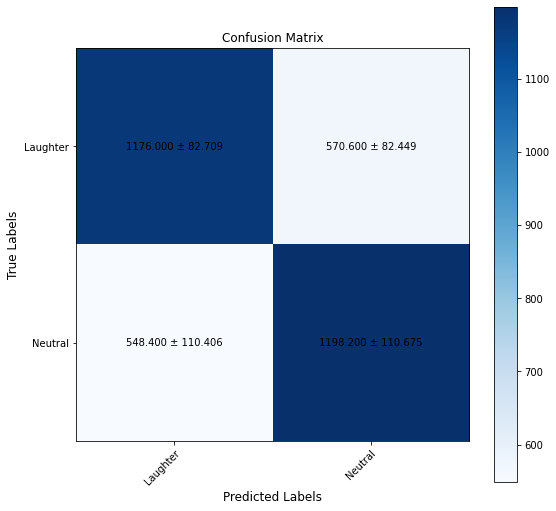

In [0]:
mean_confusions = np.mean(np.array(conf_matrices), axis = 0)
std_confusions = np.std(np.array(conf_matrices), axis = 0)

label_names = ["Laughter", "Neutral"]

fig, ax = plt.subplots(figsize = (8, 8))
im = ax.imshow(mean_confusions, cmap = "Blues")

# We want to show all ticks...
ax.set_xticks(np.arange(len(label_names)))
ax.set_yticks(np.arange(len(label_names)))
# ... and label them with the respective list entries
ax.set_xticklabels(label_names)
ax.set_yticklabels(label_names)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.xlabel("Predicted Labels", fontsize = 'large')
plt.ylabel("True Labels", fontsize = 'large')
# Loop over data dimensions and create text annotations.
for i in range(len(label_names)):
    for j in range(len(label_names)):
        text = ax.text(j, i, f'{mean_confusions[i, j]:.3f} ± {std_confusions[i, j]:.3f}',
                       ha="center", va="center", color="black")

ax.set_title("Confusion Matrix")
fig.tight_layout()
plt.colorbar(im)
plt.show()